In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import os
from torchvision.models import inception_v3
from scipy.linalg import sqrtm
from torchsummary import summary as Summary

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

latent_dim = 128
batch_size = 64
lr = 5e-5
img_shape = (3, 32, 32)
n_epochs = 50
n_critic = 5
c = 0.01

print(device)

cuda


In [3]:
# Load Inception-v3 in eval mode
inception = inception_v3(pretrained=True, transform_input=False)
inception.fc = torch.nn.Identity()  # Remove final classification layer
inception.aux_logits = False
inception.eval()

if torch.cuda.is_available():
    inception = inception.cuda()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 203MB/s] 


In [4]:
def preprocess_images(images):
    """Preprocess images for Inception-v3"""
    # Ensure images are in [0, 1] range
    if images.min() >= -1.0 and images.max() <= 1.0:
        # Input is in [-1, 1] range (GAN output)
        images = (images + 1.0) / 2.0
    elif images.max() > 1.0:
        # Input is in [0, 255] range
        images = images / 255.0
    else:
        # Already in [0, 1] range
        pass

    # Clamp to [0, 1]
    images = torch.clamp(images, 0.0, 1.0)

    # Resize to 299x299
    images = F.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)

    # ImageNet normalization
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)

    if images.is_cuda:
        mean = mean.cuda()
        std = std.cuda()

    images = (images - mean) / std
    return images

In [5]:
def get_features(images, model):
    """Extract features using Inception-v3 (2048D from pool3 layer)"""
    model.eval()
    with torch.no_grad():
        if torch.cuda.is_available():
            images = images.cuda()

        # Preprocess images properly
        images = preprocess_images(images)

        # Use the standard forward pass to get pool3 features (2048D)
        # This automatically handles all the layers correctly
        features = model(images)  # This gives us the final pooled features

        # If features are still 2D (batch_size, features), we're good
        # If they're 4D, we need to pool them
        if len(features.shape) == 4:
            features = F.adaptive_avg_pool2d(features, (1, 1))
            features = torch.flatten(features, 1)

    return features.cpu()

In [6]:
def calculate_stats(features):
    """Calculate mean and covariance matrix"""
    features = features.numpy().astype(np.float64)  # Use float64 for numerical stability
    mu = np.mean(features, axis=0)
    sigma = np.cov(features, rowvar=False)
    return mu, sigma

In [7]:
def calculate_fid(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Calculate FID score"""
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    # Ensure matrices are symmetric (numerical stability)
    sigma1 = (sigma1 + sigma1.T) / 2
    sigma2 = (sigma2 + sigma2.T) / 2

    # Add small epsilon to diagonal for numerical stability
    sigma1 += eps * np.eye(sigma1.shape[0])
    sigma2 += eps * np.eye(sigma2.shape[0])

    diff = mu1 - mu2

    # Calculate sqrt of product of covariance matrices
    try:
        covmean, _ = sqrtm(sigma1.dot(sigma2), disp=False)
    except Exception as e:
        print(f"Error in sqrtm: {e}")
        # Fallback: add more regularization
        sigma1 += eps * 10 * np.eye(sigma1.shape[0])
        sigma2 += eps * 10 * np.eye(sigma2.shape[0])
        covmean, _ = sqrtm(sigma1.dot(sigma2), disp=False)

    # Handle numerical errors in sqrtm
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.absolute(covmean.imag))
            raise ValueError(f"Imaginary component {m}")
        covmean = covmean.real

    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

In [8]:
def compute_fid(real_images, fake_images, batch_size=64):
    """Compute FID between real and fake images"""
    # Create data loaders
    real_loader = DataLoader(real_images, batch_size=batch_size, shuffle=False)
    fake_loader = DataLoader(fake_images, batch_size=batch_size, shuffle=False)

    # Process real images
    real_features = []
    for batch in real_loader:
        real_features.append(get_features(batch, inception))
    real_features = torch.cat(real_features, dim=0)

    # Process fake images
    fake_features = []
    for batch in fake_loader:
        fake_features.append(get_features(batch, inception))
    fake_features = torch.cat(fake_features, dim=0)

    # Calculate statistics
    mu_real, sigma_real = calculate_stats(real_features)
    mu_fake, sigma_fake = calculate_stats(fake_features)

    return calculate_fid(mu_real, sigma_real, mu_fake, sigma_fake)

In [9]:
def evaluate_fid(generator, dataloader, sample_size, batch_size_fid, latent_dim, device):
    """Evaluate FID score for a generator"""
    generator.eval()

    # Generate fake images
    fake_images = []
    with torch.no_grad():
        for j in range(0, sample_size, batch_size_fid):
            current_batch = min(batch_size_fid, sample_size - j)
            z = torch.randn(current_batch, latent_dim).to(device)
            fake_batch = generator(z).cpu()
            fake_images.append(fake_batch)
    fake_images = torch.cat(fake_images, dim=0)

    # Collect real images
    real_images = []
    total_collected = 0
    for imgs, _ in dataloader:
        real_images.append(imgs)
        total_collected += imgs.size(0)
        if total_collected >= sample_size:
            break

    real_images = torch.cat(real_images, dim=0)[:sample_size]

    # Ensure we have the same number of real and fake images
    min_size = min(len(real_images), len(fake_images))
    real_images = real_images[:min_size]
    fake_images = fake_images[:min_size]

    # Compute FID
    fid = compute_fid(real_images, fake_images)

    generator.train()
    return fid

In [10]:
selected_classes = [2,3,4,5,6,7]

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

full_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)

class CIFAR10Subset(Dataset):
    def __init__(self, root, train=True, selected_labels=None, transform=None):
        self.full_dataset = full_dataset
        self.selected_labels = selected_labels if selected_labels is not None else list(range(10))
        self.indices = [i for i, (_, label) in enumerate(self.full_dataset) if label in self.selected_labels]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        true_idx = self.indices[idx]
        img, label = self.full_dataset[true_idx]
        return img, label

subset = CIFAR10Subset(root='./data', train=True, selected_labels=selected_classes, transform=transform)
dataloader = DataLoader(subset, batch_size=64, shuffle=True)

dataloader_2 = DataLoader(
    dataset=full_dataset,
    batch_size=batch_size,      
    shuffle=False,      
    num_workers=2,
    pin_memory=True
)

100%|██████████| 170M/170M [00:10<00:00, 15.8MB/s] 


In [11]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128 * 8 * 8),
            nn.ReLU(),
            nn.Unflatten(1, (128, 8, 8)),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128, momentum=0.78),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64, momentum=0.78),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img

generator = Generator(latent_dim).to(device)
print(Summary(generator, input_size=(latent_dim,), batch_size=batch_size, device="cuda"))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [64, 8192]       1,056,768
              ReLU-2                 [64, 8192]               0
         Unflatten-3            [64, 128, 8, 8]               0
          Upsample-4          [64, 128, 16, 16]               0
            Conv2d-5          [64, 128, 16, 16]         147,584
       BatchNorm2d-6          [64, 128, 16, 16]             256
              ReLU-7          [64, 128, 16, 16]               0
          Upsample-8          [64, 128, 32, 32]               0
            Conv2d-9           [64, 64, 32, 32]          73,792
      BatchNorm2d-10           [64, 64, 32, 32]             128
             ReLU-11           [64, 64, 32, 32]               0
           Conv2d-12            [64, 3, 32, 32]           1,731
             Tanh-13            [64, 3, 32, 32]               0
Total params: 1,280,259
Trainable param

In [12]:
class Critic(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            # Input: 3 x 32 x 32
            nn.Conv2d(3, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout2d(0.1),
            # 64 x 16 x 16

            nn.Conv2d(128,256 , kernel_size=4, stride=2, padding=1, bias=False),
            nn.LayerNorm([256, 8, 8]),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout2d(0.1),
            # 128 x 8 x 8

            nn.Conv2d(256,512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LayerNorm([512,4,4]),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout2d(0.1),
            # 256 x 4 x 4

            # Global average pooling instead of another conv layer
            nn.AdaptiveAvgPool2d(1),  # 256 x 1 x 1
            nn.Flatten(),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        return self.model(x)

critic = Critic().to(device)
print(Summary(critic, (3, 32, 32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 16, 16]           6,144
         LeakyReLU-2          [-1, 128, 16, 16]               0
         Dropout2d-3          [-1, 128, 16, 16]               0
            Conv2d-4            [-1, 256, 8, 8]         524,288
         LayerNorm-5            [-1, 256, 8, 8]          32,768
         LeakyReLU-6            [-1, 256, 8, 8]               0
         Dropout2d-7            [-1, 256, 8, 8]               0
            Conv2d-8            [-1, 512, 4, 4]       2,097,152
         LayerNorm-9            [-1, 512, 4, 4]          16,384
        LeakyReLU-10            [-1, 512, 4, 4]               0
        Dropout2d-11            [-1, 512, 4, 4]               0
AdaptiveAvgPool2d-12            [-1, 512, 1, 1]               0
          Flatten-13                  [-1, 512]               0
           Linear-14                   

In [14]:
def show_imgs(real_imgs, gen_imgs, n=10):
    """Display real and generated images side by side"""
    n = min(n, len(real_imgs), len(gen_imgs))  # Ensure we don't exceed available images

    real = real_imgs[:n].cpu().detach()
    fake = gen_imgs[:n].cpu().detach()

    # Rescale from [-1, 1] to [0, 1]
    real = (real + 1) / 2
    fake = (fake + 1) / 2

    fig, axes = plt.subplots(2, n, figsize=(2*n, 4))

    # Handle case where n=1 (axes won't be 2D)
    if n == 1:
        axes = axes.reshape(2, 1)

    for i in range(n):
        # Real images on top row
        real_img = real[i].permute(1, 2, 0).numpy()
        axes[0, i].imshow(real_img, vmin=0, vmax=1)
        axes[0, i].axis("off")
        if i == 0:
            axes[0, i].set_title("Real Images")

        # Fake images on bottom row
        fake_img = fake[i].permute(1, 2, 0).numpy()
        axes[1, i].imshow(fake_img, vmin=0, vmax=1)
        axes[1, i].axis("off")
        if i == 0:
            axes[1, i].set_title("Generated Images")

    plt.tight_layout()
    plt.show()

In [15]:
def train_WGAN(generator, critic, optimizer_g, optimizer_c, dataloader, device, latent_dim, n_critic , c , n_epochs , fid_0):
    os.makedirs("images_WGAN", exist_ok=True)

    g_losses = []
    c_losses = []
    fid_scores = []
    fid_scores.append(fid_0)  # Adding the fid value of noise genertaed by the generator before Training

    for epoch in range(1 , n_epochs+1):
        g_loss_epoch = 0.0  # Intialised the loss variables
        c_loss_epoch = 0.0
        batches = 0

        for i, (imgs, _) in enumerate(dataloader):
            real_imgs = imgs.to(device)
            batches += 1
            c_loss_n = 0.0
            b_size = imgs.size(0)  # to track the current batch size

            for _ in range(n_critic):
                optimizer_c.zero_grad()

                z = torch.randn(b_size, latent_dim).to(device)
                fake_imgs = generator(z).detach()

                real_validity = critic(real_imgs)
                fake_validity = critic(fake_imgs)

                loss_c = - (torch.mean(real_validity) - torch.mean(fake_validity))   # loss of Critic = max ( E(D(x)) - E(G(z)) )
                c_loss_n += loss_c.item()                                            # maximising the loss = minimising the the -ve of loss as optimizers are used to reduce the loss values
                loss_c.backward()
                optimizer_c.step()

                for p in critic.parameters():           # Weight Clipping
                    p.data.clamp_(-c, c)

            c_loss_epoch += (c_loss_n / n_critic)   # taking Avg of all the losses for n_critic

            optimizer_g.zero_grad()
            z = torch.randn(b_size, latent_dim).to(device)
            gen_imgs = generator(z)
            gen_validity = critic(gen_imgs)
            loss_g = - torch.mean(gen_validity)   # loss of Generator = min( - E(D(G(z))) )
            g_loss_epoch += loss_g.item()         # and we will keep it as it is as optimisers are already doing this
            loss_g.backward()
            optimizer_g.step()

        avg_c_loss = c_loss_epoch / batches
        avg_g_loss = g_loss_epoch / batches

        g_losses.append(avg_g_loss)
        c_losses.append(avg_c_loss)

        fid_score = evaluate_fid(generator, dataloader, 5000 , 100 , latent_dim, device)  # Computing the FID in each epoch
        fid_scores.append(fid_score)

        print(f"[Epoch {epoch}/{n_epochs}] Loss D: {avg_c_loss:.4f}, Loss G: {avg_g_loss:.4f} , FID score : {fid_score:.4f}")

        # Printing The Results for every 25th iteration

        if epoch % 25 == 0:
            noise = torch.randn(15,latent_dim).to(device)
            with torch.no_grad():
              gen_images = generator(noise).to(device)
            save_image(gen_images.data[:10], f"images_WGAN/{epoch}.png", nrow=5, normalize=True)
            show_imgs(real_imgs, gen_images, n=10)

    # Plotting The Curves

    plt.figure(figsize=(10, 5))
    plt.plot(g_losses, label='Generator Loss')
    plt.plot(c_losses, label='Critic Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Average Loss")
    plt.title("WGAN Loss per Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(10, 5))
    plt.plot(fid_scores, label='FID Score')
    plt.xlabel("Epoch")
    plt.ylabel("FID")
    plt.title("FID Score per Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return fid_scores

Before Training...


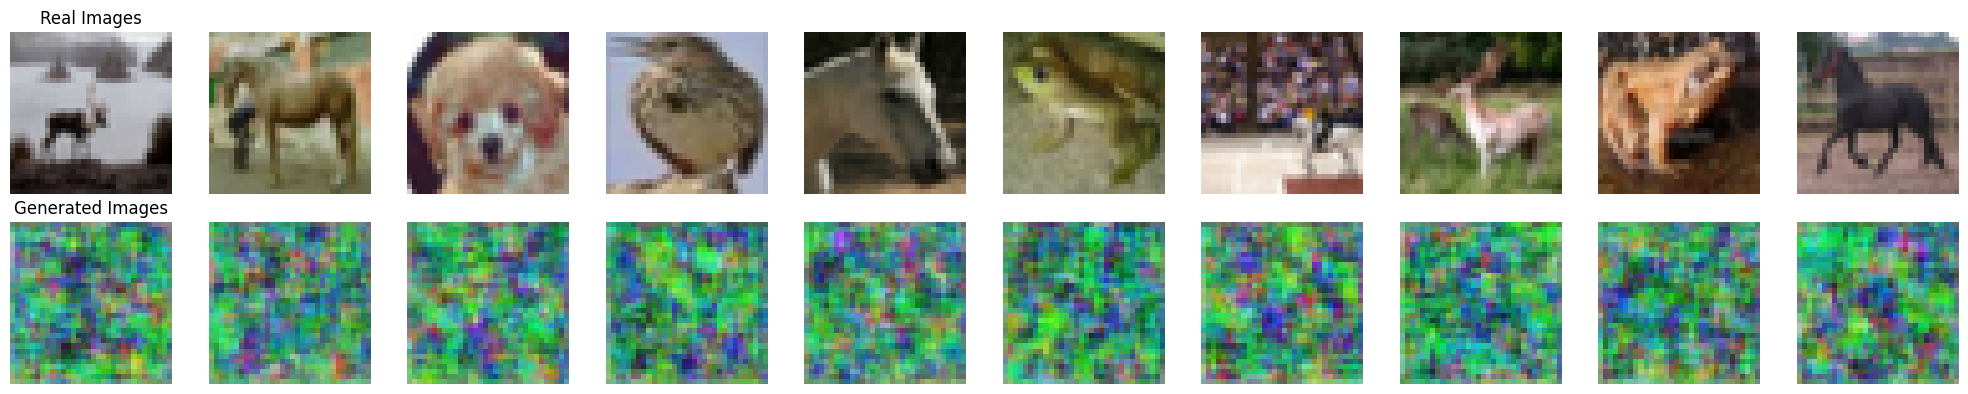

 FID : 372.3746432995405
Training started...
[Epoch 1/50] Loss D: -0.0560, Loss G: 0.0406 , FID score : 158.0512
[Epoch 2/50] Loss D: -0.0612, Loss G: 0.0422 , FID score : 121.2310
[Epoch 3/50] Loss D: -0.0627, Loss G: 0.0424 , FID score : 115.7884
[Epoch 4/50] Loss D: -0.0603, Loss G: 0.0414 , FID score : 103.5131
[Epoch 5/50] Loss D: -0.0576, Loss G: 0.0407 , FID score : 100.7910
[Epoch 6/50] Loss D: -0.0558, Loss G: 0.0396 , FID score : 96.6774
[Epoch 7/50] Loss D: -0.0536, Loss G: 0.0386 , FID score : 95.9879
[Epoch 8/50] Loss D: -0.0511, Loss G: 0.0371 , FID score : 93.8844
[Epoch 9/50] Loss D: -0.0495, Loss G: 0.0364 , FID score : 90.7908
[Epoch 10/50] Loss D: -0.0478, Loss G: 0.0355 , FID score : 88.4649
[Epoch 11/50] Loss D: -0.0464, Loss G: 0.0350 , FID score : 85.2632
[Epoch 12/50] Loss D: -0.0450, Loss G: 0.0341 , FID score : 83.5984
[Epoch 13/50] Loss D: -0.0438, Loss G: 0.0333 , FID score : 81.3869
[Epoch 14/50] Loss D: -0.0423, Loss G: 0.0329 , FID score : 80.0586
[Epoch 

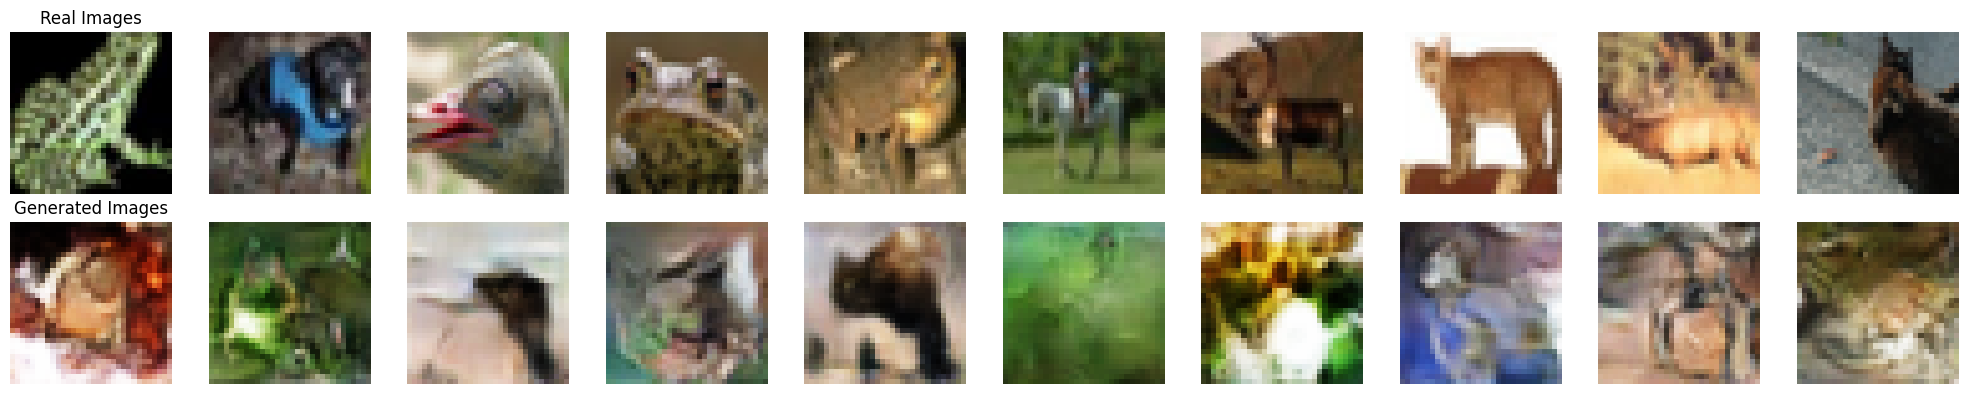

[Epoch 26/50] Loss D: -0.0318, Loss G: 0.0274 , FID score : 66.3634
[Epoch 27/50] Loss D: -0.0313, Loss G: 0.0271 , FID score : 61.6870
[Epoch 28/50] Loss D: -0.0308, Loss G: 0.0271 , FID score : 60.7272
[Epoch 29/50] Loss D: -0.0304, Loss G: 0.0268 , FID score : 60.3877
[Epoch 30/50] Loss D: -0.0299, Loss G: 0.0258 , FID score : 66.7394
[Epoch 31/50] Loss D: -0.0295, Loss G: 0.0266 , FID score : 59.3901
[Epoch 32/50] Loss D: -0.0293, Loss G: 0.0260 , FID score : 57.5303
[Epoch 33/50] Loss D: -0.0289, Loss G: 0.0260 , FID score : 57.6624
[Epoch 34/50] Loss D: -0.0285, Loss G: 0.0248 , FID score : 56.8493
[Epoch 35/50] Loss D: -0.0282, Loss G: 0.0252 , FID score : 58.4487
[Epoch 36/50] Loss D: -0.0278, Loss G: 0.0253 , FID score : 59.0874
[Epoch 37/50] Loss D: -0.0277, Loss G: 0.0251 , FID score : 55.2010
[Epoch 38/50] Loss D: -0.0273, Loss G: 0.0253 , FID score : 55.9678
[Epoch 39/50] Loss D: -0.0271, Loss G: 0.0250 , FID score : 59.5050
[Epoch 40/50] Loss D: -0.0267, Loss G: 0.0246 , 

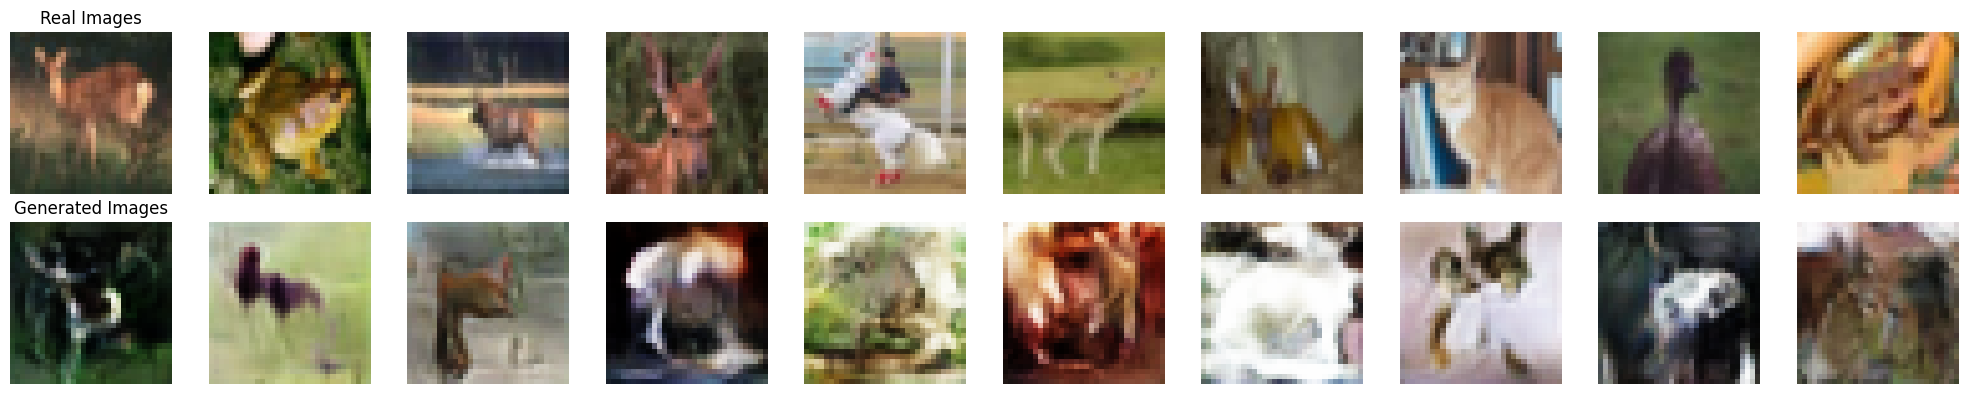

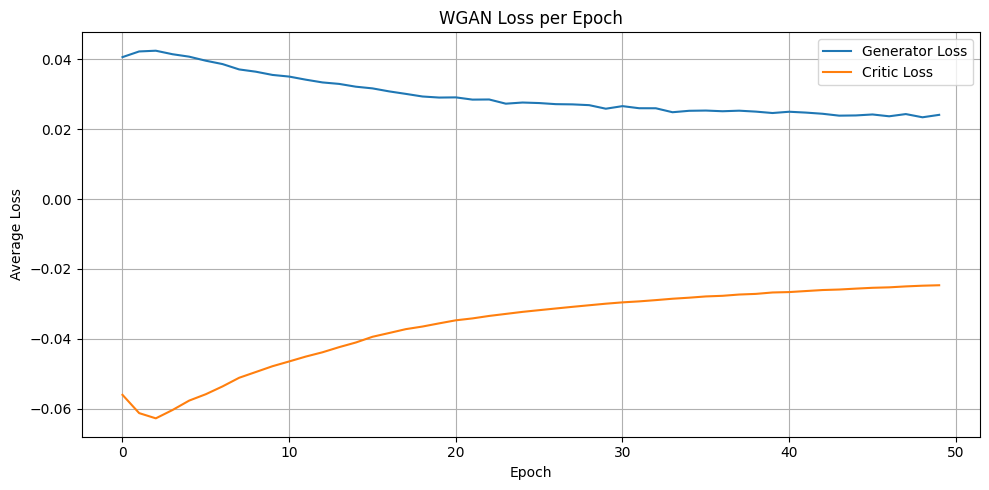

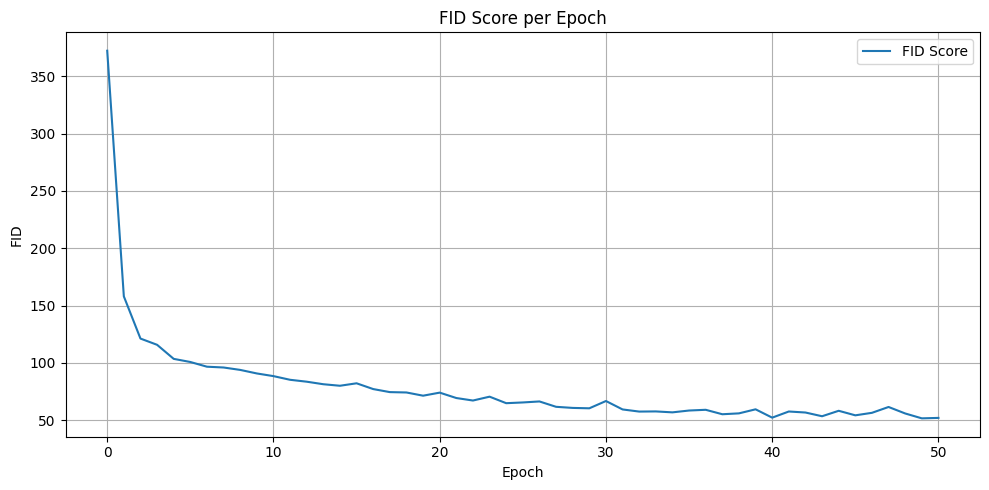

In [17]:
generator_1 = Generator(latent_dim).to(device)
critic_1 = Critic().to(device)
optimizer_g1 = optim.RMSprop(generator_1.parameters(), lr=lr)
optimizer_c1 = optim.RMSprop(critic_1.parameters(), lr=lr)

with torch.no_grad():
    noise = torch.randn(10, latent_dim).to(device)
    gen_imgs = generator_1(noise)

# Get real images for comparison
for imgs, _ in dataloader:
    real_imgs = imgs.to(device)
    break
print("Before Training...")
val = evaluate_fid(generator_1, dataloader, 5000 , 100 , latent_dim, device)
show_imgs(real_imgs, gen_imgs, n=10)
print(f" FID : {val}")
print("Training started...")

# Start training
fid_1 = train_WGAN(generator_1, critic_1, optimizer_g1, optimizer_c1, dataloader, device, latent_dim, n_critic , c , n_epochs , val)

Before Training...


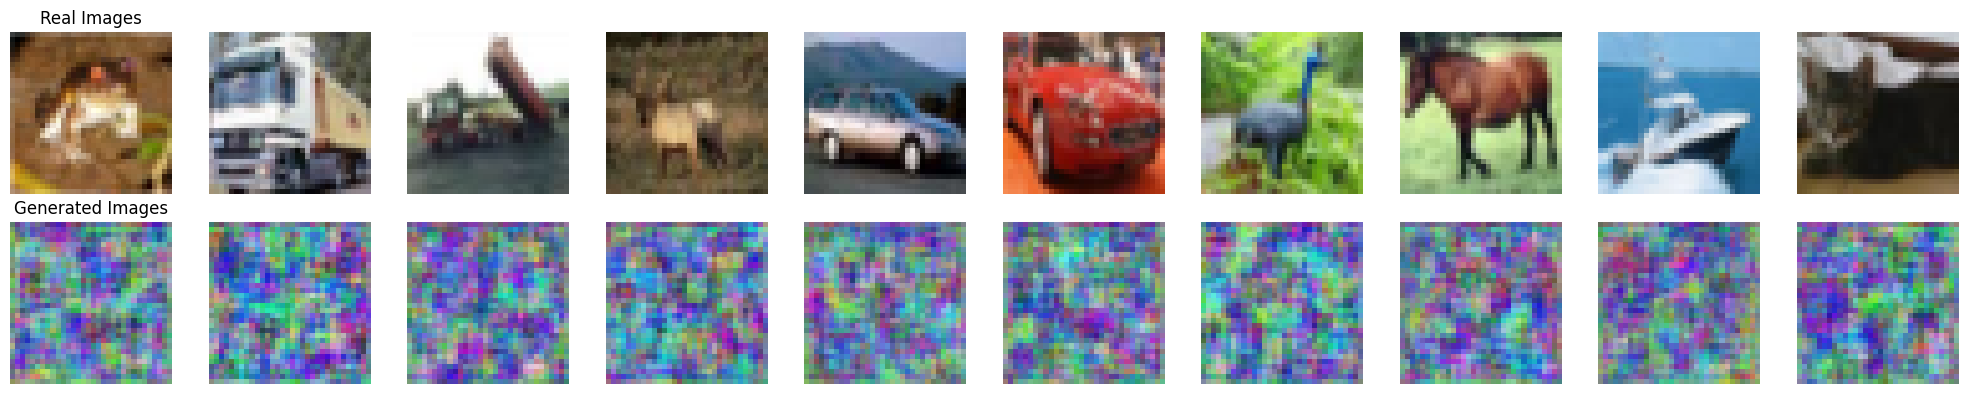

 FID : 412.8696053831886
Training started...
[Epoch 1/100] Loss D: -0.0628, Loss G: 0.0219 , FID score : 152.1408
[Epoch 2/100] Loss D: -0.0668, Loss G: 0.0228 , FID score : 133.1296
[Epoch 3/100] Loss D: -0.0572, Loss G: 0.0188 , FID score : 119.0846
[Epoch 4/100] Loss D: -0.0534, Loss G: 0.0170 , FID score : 107.9830
[Epoch 5/100] Loss D: -0.0520, Loss G: 0.0159 , FID score : 107.9110
[Epoch 6/100] Loss D: -0.0500, Loss G: 0.0148 , FID score : 96.6964
[Epoch 7/100] Loss D: -0.0481, Loss G: 0.0138 , FID score : 99.6283
[Epoch 8/100] Loss D: -0.0464, Loss G: 0.0129 , FID score : 91.6055
[Epoch 9/100] Loss D: -0.0449, Loss G: 0.0120 , FID score : 79.9949
[Epoch 10/100] Loss D: -0.0432, Loss G: 0.0112 , FID score : 80.3609
[Epoch 11/100] Loss D: -0.0417, Loss G: 0.0104 , FID score : 74.1661
[Epoch 12/100] Loss D: -0.0401, Loss G: 0.0096 , FID score : 73.7969
[Epoch 13/100] Loss D: -0.0388, Loss G: 0.0093 , FID score : 71.9784
[Epoch 14/100] Loss D: -0.0375, Loss G: 0.0083 , FID score : 7

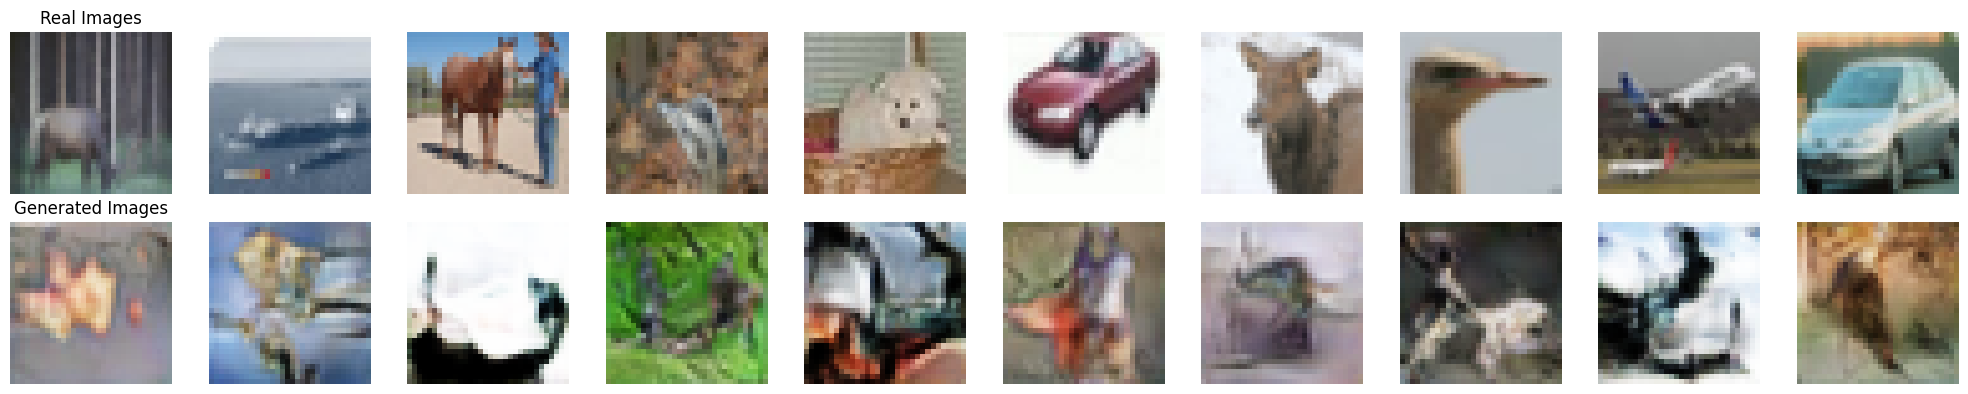

[Epoch 26/100] Loss D: -0.0284, Loss G: 0.0038 , FID score : 58.7205
[Epoch 27/100] Loss D: -0.0279, Loss G: 0.0031 , FID score : 61.1514
[Epoch 28/100] Loss D: -0.0275, Loss G: 0.0029 , FID score : 57.3363
[Epoch 29/100] Loss D: -0.0270, Loss G: 0.0036 , FID score : 57.2569
[Epoch 30/100] Loss D: -0.0266, Loss G: 0.0031 , FID score : 60.1970
[Epoch 31/100] Loss D: -0.0262, Loss G: 0.0024 , FID score : 55.2817
[Epoch 32/100] Loss D: -0.0258, Loss G: 0.0026 , FID score : 55.4405
[Epoch 33/100] Loss D: -0.0254, Loss G: 0.0025 , FID score : 53.4231
[Epoch 34/100] Loss D: -0.0251, Loss G: 0.0022 , FID score : 55.7891
[Epoch 35/100] Loss D: -0.0248, Loss G: 0.0021 , FID score : 56.7893
[Epoch 36/100] Loss D: -0.0245, Loss G: 0.0027 , FID score : 56.7751
[Epoch 37/100] Loss D: -0.0242, Loss G: 0.0020 , FID score : 57.8157
[Epoch 38/100] Loss D: -0.0240, Loss G: 0.0014 , FID score : 56.7623
[Epoch 39/100] Loss D: -0.0236, Loss G: 0.0018 , FID score : 57.5616
[Epoch 40/100] Loss D: -0.0235, Lo

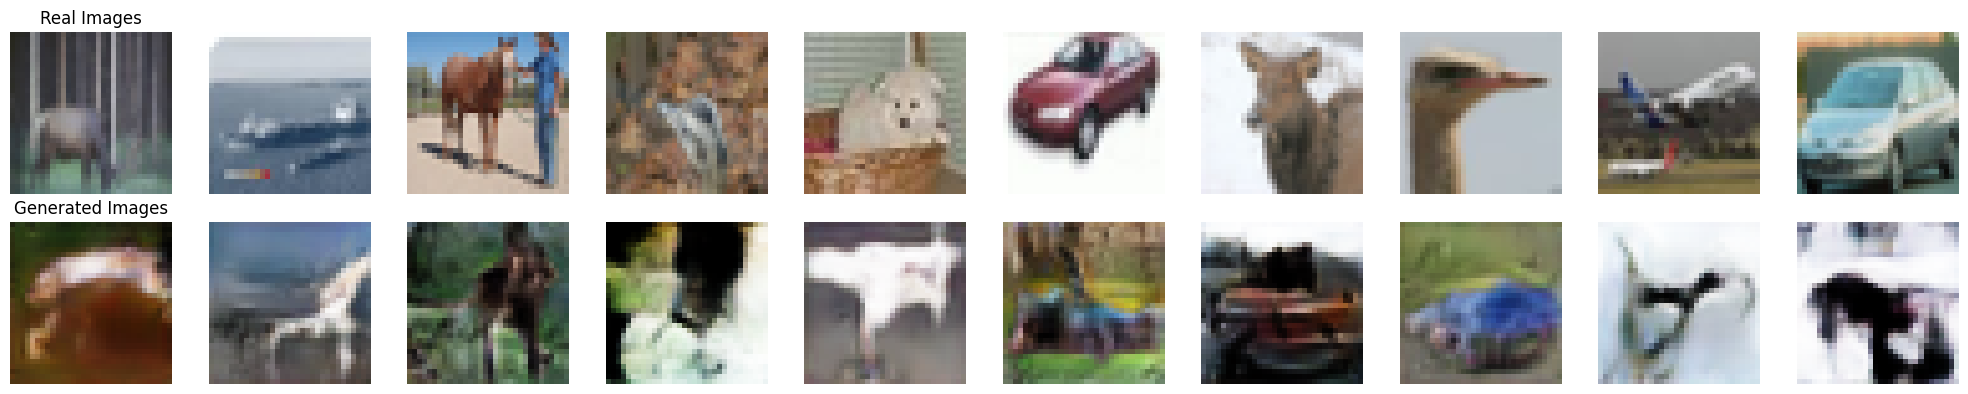

[Epoch 51/100] Loss D: -0.0213, Loss G: 0.0010 , FID score : 50.0273
[Epoch 52/100] Loss D: -0.0211, Loss G: 0.0013 , FID score : 49.7428
[Epoch 53/100] Loss D: -0.0209, Loss G: 0.0007 , FID score : 50.9486
[Epoch 54/100] Loss D: -0.0207, Loss G: 0.0008 , FID score : 49.6761
[Epoch 55/100] Loss D: -0.0207, Loss G: 0.0002 , FID score : 56.7434
[Epoch 56/100] Loss D: -0.0204, Loss G: -0.0002 , FID score : 53.8959
[Epoch 57/100] Loss D: -0.0203, Loss G: 0.0003 , FID score : 48.8124
[Epoch 58/100] Loss D: -0.0201, Loss G: 0.0007 , FID score : 51.6057
[Epoch 59/100] Loss D: -0.0200, Loss G: 0.0003 , FID score : 50.3367
[Epoch 60/100] Loss D: -0.0199, Loss G: 0.0010 , FID score : 54.0699
[Epoch 61/100] Loss D: -0.0197, Loss G: -0.0002 , FID score : 52.1085
[Epoch 62/100] Loss D: -0.0196, Loss G: 0.0003 , FID score : 48.7454
[Epoch 63/100] Loss D: -0.0194, Loss G: 0.0005 , FID score : 50.6357
[Epoch 64/100] Loss D: -0.0195, Loss G: 0.0005 , FID score : 51.5458
[Epoch 65/100] Loss D: -0.0192, 

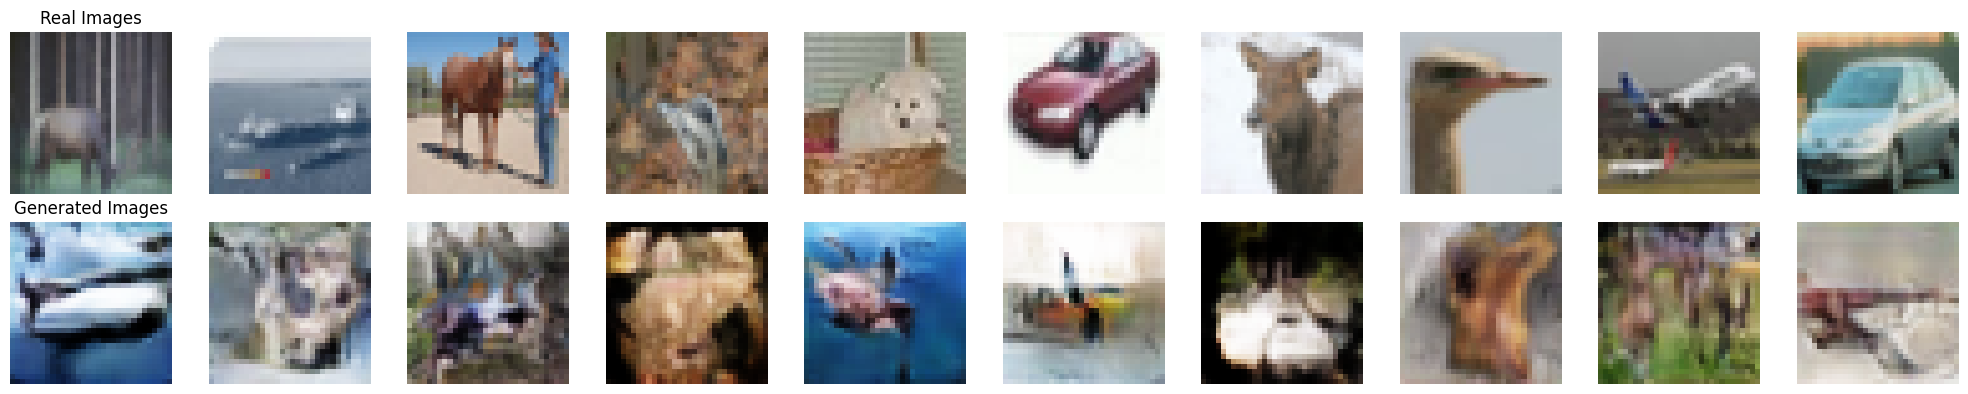

[Epoch 76/100] Loss D: -0.0181, Loss G: 0.0000 , FID score : 48.0755
[Epoch 77/100] Loss D: -0.0180, Loss G: -0.0001 , FID score : 49.0895
[Epoch 78/100] Loss D: -0.0179, Loss G: -0.0005 , FID score : 48.0301
[Epoch 79/100] Loss D: -0.0179, Loss G: -0.0012 , FID score : 47.5573
[Epoch 80/100] Loss D: -0.0178, Loss G: 0.0009 , FID score : 50.1314
[Epoch 81/100] Loss D: -0.0177, Loss G: -0.0001 , FID score : 44.6377
[Epoch 82/100] Loss D: -0.0177, Loss G: -0.0003 , FID score : 46.7271
[Epoch 83/100] Loss D: -0.0176, Loss G: -0.0002 , FID score : 44.5800
[Epoch 84/100] Loss D: -0.0174, Loss G: -0.0006 , FID score : 51.1450
[Epoch 85/100] Loss D: -0.0174, Loss G: -0.0011 , FID score : 47.8375
[Epoch 86/100] Loss D: -0.0174, Loss G: -0.0004 , FID score : 53.7251
[Epoch 87/100] Loss D: -0.0172, Loss G: -0.0001 , FID score : 48.7426
[Epoch 88/100] Loss D: -0.0172, Loss G: 0.0007 , FID score : 46.9755
[Epoch 89/100] Loss D: -0.0171, Loss G: 0.0001 , FID score : 46.7578
[Epoch 90/100] Loss D: -

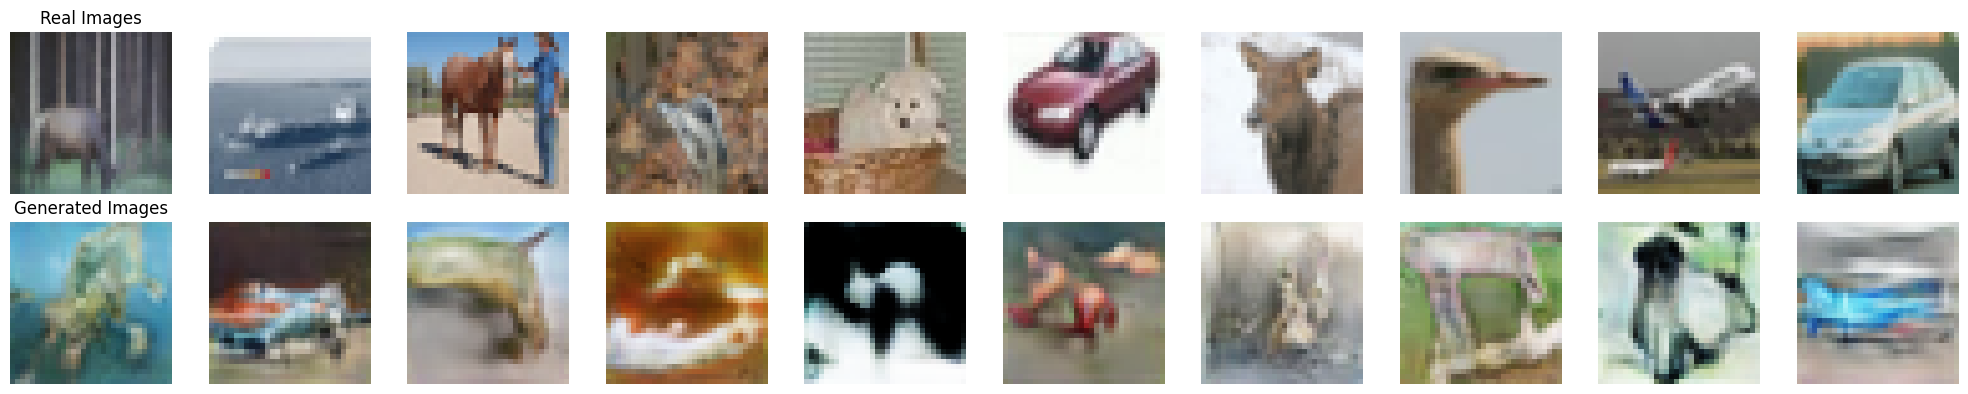

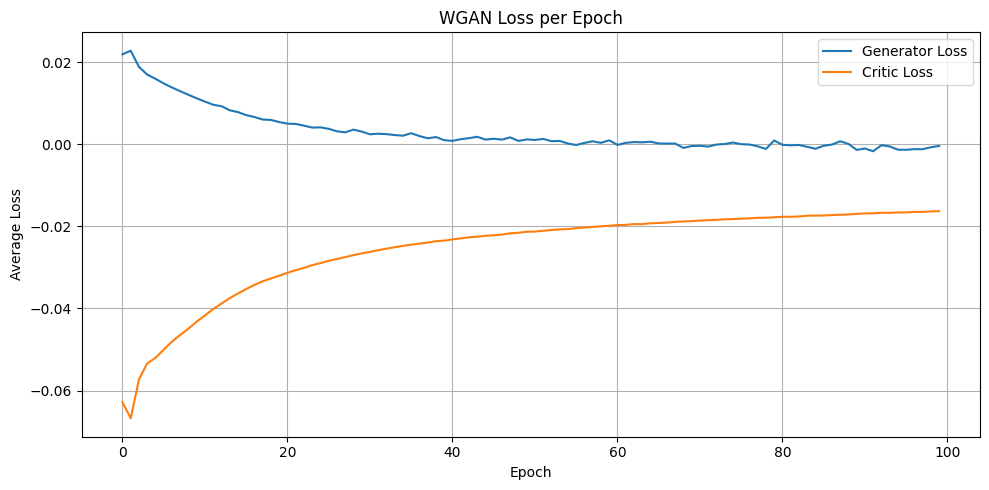

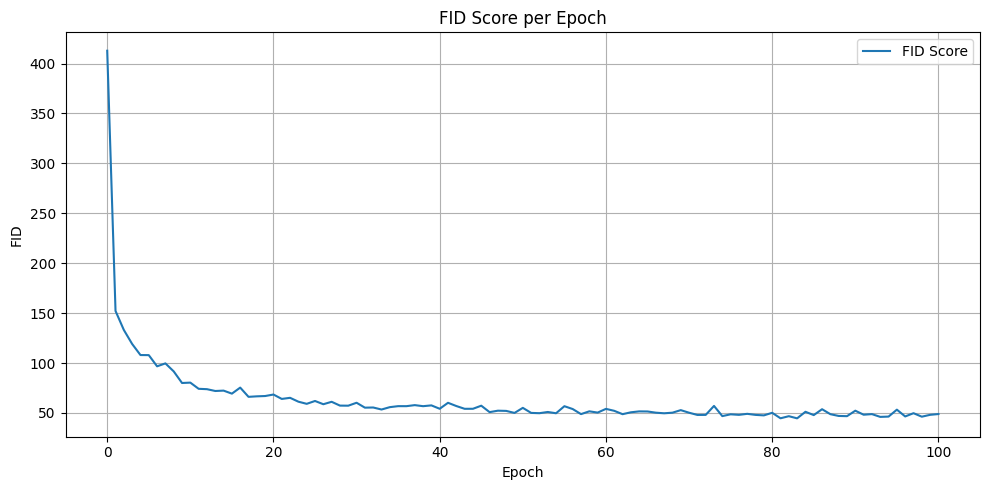

In [18]:
generator_2 = Generator(latent_dim).to(device)
critic_2 = Critic().to(device)
optimizer_g2 = optim.RMSprop(generator_2.parameters(), lr=lr)
optimizer_c2 = optim.RMSprop(critic_2.parameters(), lr=lr)

with torch.no_grad():
    noise = torch.randn(10, latent_dim).to(device)
    gen_imgs = generator_2(noise)

# Get real images for comparison
for imgs, _ in dataloader_2:
    real_imgs = imgs.to(device)
    break
print("Before Training...")
val = evaluate_fid(generator_2, dataloader_2, 5000 , 100 , latent_dim, device)
show_imgs(real_imgs, gen_imgs, n=10)
print(f" FID : {val}")
print("Training started...")

# Start training
fid_2 = train_WGAN(generator_2, critic_2, optimizer_g2, optimizer_c2, dataloader_2, device, latent_dim, n_critic , c , 100 , val)

In [ ]:
import pickle
fid_old = pickle.load(open('fid_old.pkl', 'rb'))

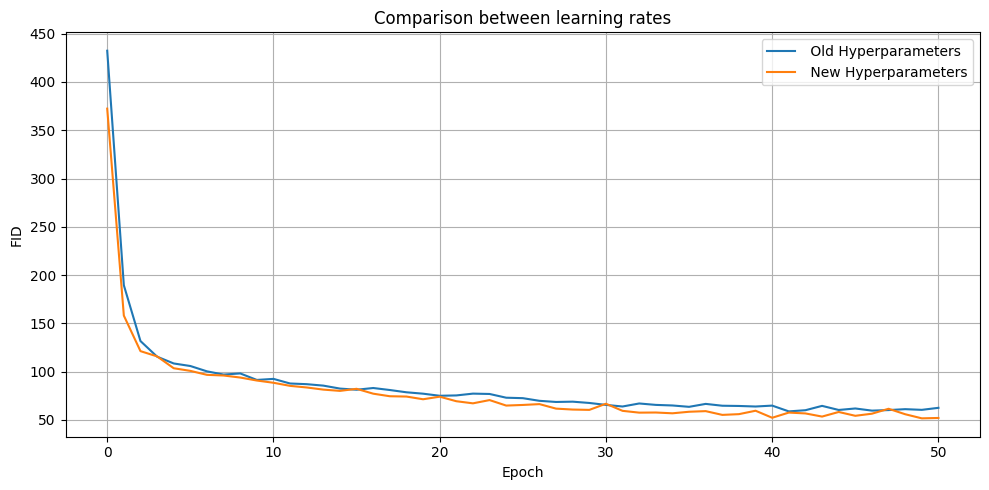

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(fid_old ,label=' Old Hyperparameters')
plt.plot(fid_1 ,label=' New Hyperparameters')
plt.xlabel("Epoch")
plt.ylabel("FID")
plt.title("Comparison between learning rates")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

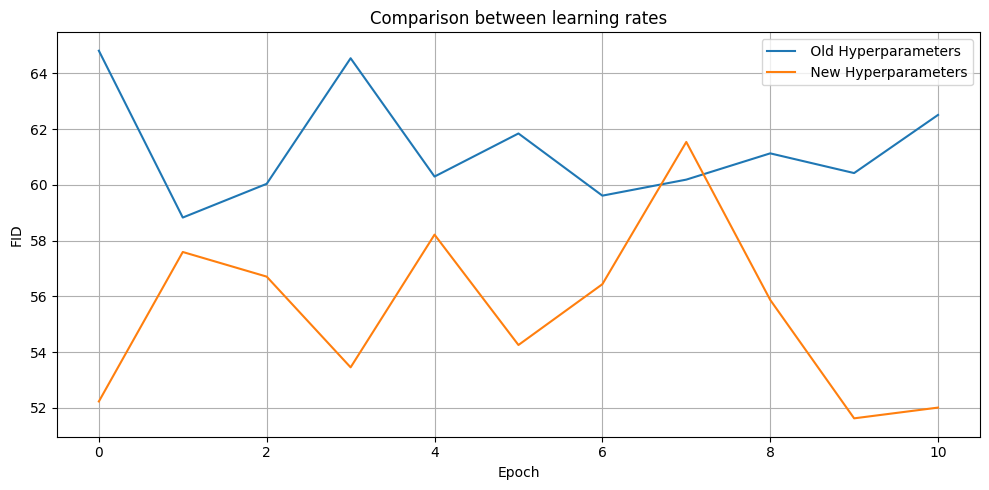

In [ ]:
fid_1 = fid_1[40:]
fid_old = fid_old[40:]
plt.figure(figsize=(10, 5))
plt.plot(fid_old ,label=' Old Hyperparameters')
plt.plot(fid_1 ,label=' New Hyperparameters')
plt.xlabel("Epoch")
plt.ylabel("FID")
plt.title("Comparison between learning rates")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()